In [62]:
%matplotlib inline
import pymc3 as pm
import theano.tensor as T
import theano
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets
from sklearn.preprocessing import scale
from sklearn.cross_validation import train_test_split
from sklearn import datasets

In [63]:
digits = datasets.load_digits()

In [64]:
X=digits.images

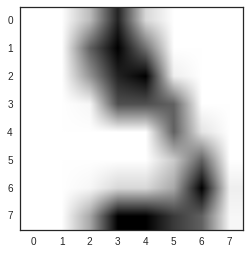

In [67]:
plt.imshow(X[19])

In [16]:
Y_=digits.target

In [18]:
def get_on_hot(number):
    on_hot=[0]*10
    on_hot[number]=1
    return on_hot

In [19]:
Y=map(get_on_hot,Y_)

In [77]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.5)

In [92]:
ann_input = theano.shared(X_train)
ann_output = theano.shared(Y_train)

In [93]:
n_hidden = 5

In [94]:
# Initialize random weights between each layer
init_1 = np.random.randn(X.shape[1], n_hidden)
init_2 = np.random.randn(n_hidden, n_hidden)
init_out = np.random.randn(n_hidden)

In [95]:
with pm.Model() as neural_network:
    # Weights from input to hidden layer
    weights_in_1 = pm.Normal('w_in_1', 0, sd=1, 
                             shape=(X.shape[1], n_hidden), 
                             testval=init_1)
    # Weights from 1st to 2nd layer
    weights_1_2 = pm.Normal('w_1_2', 0, sd=1, 
                            shape=(n_hidden, n_hidden), 
                            testval=init_2)
    # Weights from hidden layer to output
    weights_2_out = pm.Normal('w_2_out', 0, sd=1, 
                              shape=(n_hidden,), 
                              testval=init_out)
      # Build neural-network using tanh activation function
    act_1 = T.tanh(T.dot(ann_input, 
                         weights_in_1))
    act_2 = T.tanh(T.dot(act_1, 
                         weights_1_2))
    act_out = T.nnet.sigmoid(T.dot(act_2, 
                                   weights_2_out))
    
    

In [96]:
%%time
with neural_network:
    # Run ADVI which returns posterior means, standard deviations, and the evidence lower bound (ELBO)
    v_params = pm.variational.advi(n=50000)

Iteration 0 [0%]: ELBO = -16.67
Iteration 5000 [10%]: Average ELBO = -14.43
Iteration 10000 [20%]: Average ELBO = -1.9
Iteration 15000 [30%]: Average ELBO = -0.63
Iteration 20000 [40%]: Average ELBO = -0.67
Iteration 25000 [50%]: Average ELBO = -0.41
Iteration 30000 [60%]: Average ELBO = -0.55
Iteration 35000 [70%]: Average ELBO = -0.5
Iteration 40000 [80%]: Average ELBO = -0.66
Iteration 45000 [90%]: Average ELBO = -0.52
Finished [100%]: Average ELBO = -0.5
CPU times: user 5.66 s, sys: 15.1 ms, total: 5.67 s
Wall time: 5.66 s


In [97]:
with neural_network:
    trace = pm.variational.sample_vp(v_params, draws=5000)

In [99]:
# Replace shared variables with testing set
ann_input.set_value(X_test)
ann_output.set_value(Y_test)

# Creater posterior predictive samples
ppc = pm.sample_ppc(trace, model=neural_network, samples=500)

# Use probability of > 0.5 to assume prediction of class 1
pred = ppc['out'].mean(axis=0) > 0.5

KeyError: 'out'

In [91]:
print('Accuracy = {}%'.format((Y_test == pred).mean() * 100))

NameError: name 'pred' is not defined